In [1]:
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
import lightgbm as lgb
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

import pickle

In [3]:
college_data = pd.read_csv("/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/csvs/college_2024_pitch_type.csv")
college_heights = pd.read_csv("/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/csvs/college_height.csv")

/var/folders/z9/0qsxxzxs1hb9r22xy18sfdbc0000gn/T/ipykernel_73357/4106798530.py:1: DtypeWarning: Columns (27,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  college_data = pd.read_csv("/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/csvs/college_2024_pitch_type.csv")


In [4]:
college_data.shape

(1462896, 169)

In [5]:
[c for c in college_data.columns]

['PitchNo',
 'Date',
 'Time',
 'PAofInning',
 'PitchofPA',
 'Pitcher',
 'PitcherId',
 'PitcherThrows',
 'PitcherTeam',
 'Batter',
 'BatterId',
 'BatterSide',
 'BatterTeam',
 'PitcherSet',
 'Inning',
 'Top.Bottom',
 'Outs',
 'Balls',
 'Strikes',
 'TaggedPitchType',
 'AutoPitchType',
 'PitchCall',
 'KorBB',
 'TaggedHitType',
 'PlayResult',
 'OutsOnPlay',
 'RunsScored',
 'Notes',
 'RelSpeed',
 'VertRelAngle',
 'HorzRelAngle',
 'SpinRate',
 'SpinAxis',
 'Tilt',
 'RelHeight',
 'RelSide',
 'Extension',
 'VertBreak',
 'InducedVertBreak',
 'HorzBreak',
 'PlateLocHeight',
 'PlateLocSide',
 'ZoneSpeed',
 'VertApprAngle',
 'HorzApprAngle',
 'ZoneTime',
 'ExitSpeed',
 'Angle',
 'Direction',
 'HitSpinRate',
 'PositionAt110X',
 'PositionAt110Y',
 'PositionAt110Z',
 'Distance',
 'LastTrackedDistance',
 'Bearing',
 'HangTime',
 'pfxx',
 'pfxz',
 'x0',
 'y0',
 'z0',
 'vx0',
 'vy0',
 'vz0',
 'ax0',
 'ay0',
 'az0',
 'HomeTeam',
 'AwayTeam',
 'Stadium',
 'Level',
 'League',
 'GameID',
 'PitchUID',
 'Effec

In [6]:
if 'PUR_BOI' in college_data['PitcherTeam'].values:
    print("'PUR_BOI' is an option for PitcherTeam.")
else:
    print("'PUR_BOI' is not an option for PitcherTeam.")


'PUR_BOI' is an option for PitcherTeam.


In [7]:
# Omit Purdue Pitchers to avoid Overfitting
college_data = college_data[college_data['PitcherTeam'] != "PUR_BOI"]

college_data.shape

(1455983, 169)

## Arm Angle

#### Rename Columns to Match and Apply Model

In [8]:
college_data = college_data.rename(columns={
    'RelSide' : 'release_pos_x',
    'RelHeight' : 'release_pos_z',
    'Extension' : 'release_extension',
    'Pitcher' : 'player_name'
})

In [9]:
college_heights

,player_name,height_in_inches
0,Griffen Leiner,75
1,Walker Retz,75
2,Carl Cano,73
3,Tucker Huhn,74
4,Cooper Smith,70
...,...,...
5421,Jacob Crystal,74
5422,Kennen Smith,76
5423,Steven Freer,75
5424,Billy Hoffacker,78


In [11]:
college_data = college_data[college_data['player_name'] != "O'Brien Cameron"]

def format_name(name):
    try:
        last, first = name.split(", ")
        return f"{first} {last}"
    except ValueError:
        # Return the name as is if it doesn't match the expected format
        return name

college_data['player_name'] = college_data['player_name'].apply(format_name)

In [12]:
college_data = college_data.merge(college_heights, 
                                  on = 'player_name', 
                                  how = 'left')

In [13]:
college_data['interaction'] =  college_data['release_pos_z'] * college_data['release_extension'] * college_data['height_in_inches']
feats = ['release_pos_x', 'release_pos_z', 'release_extension', 'height_in_inches', 'interaction']

college_data = college_data.dropna(subset = feats)

college_data.shape

(1098219, 171)

### Load and Apply Arm Angle Model

In [15]:
catboost = "/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/models/best_catboost_model.pkl"

with open(catboost, 'rb') as cb_file:
    catboost_model = pickle.load(cb_file)

In [16]:
pred_arm_angle = catboost_model.predict(college_data[feats])

In [17]:
college_data['arm_angle'] = pred_arm_angle

## Run Values

In [19]:
print(college_data['PitchCall'].unique())
print(college_data['PlayResult'].unique())

['BallCalled' 'StrikeCalled' 'InPlay' 'StrikeSwinging' 'FoulBall'
 'BallinDirt' 'HitByPitch' 'BallIntentional' 'FoulBallFieldable'
 'FoulBallNotFieldable' 'FouldBallNotFieldable' 'Undefined'
 'StrkeSwinging' 'BattersInterference' 'StriekC']
['Undefined' 'Out' 'Single' 'Double' 'Sacrifice' 'HomeRun' 'Error'
 'FieldersChoice' 'Triple' 'StolenBase' 'CaughtStealing' 'SIngle'
 'homerun' 'error']


In [20]:
df_run_values = pd.read_csv("/Users/aidanbeilke/Downloads/run_values.csv")

des_dict = {
    'InPlay' : 'InPlay',
    'BallCalled': 'ball',
    'BallinDirt' : 'ball',
    'BallIntentional' : 'ball',
    'HitByPitch' : 'hit_by_pitch',
    'StrikeCalled' : 'called_strike',
    'StrikeSwinging' : 'swinging_strike',
    'StrkeSwinging' : 'swinging_strike',
    'FoulBall' : 'foul',
    'FoulBallFieldable' : 'foul',
    'FoulBallNotFieldable' : 'foul',
    'FouldBallNotFieldable' : 'foul',
    'BattersInterference' : None,
    'StriekC' : None
}

event_dic = {
    'Undefined' : None,
    'Out' : 'field_out',
    'Single' : 'single',
    'SIngle' : 'single',
    'Double' : 'double',
    'Triple' : 'triple',
    'HomeRun' : 'home_run',
    'homerun' : 'home_run',
    'Sacrifice' : 'field_out',
    'Error' : 'field_out',
    'error' : 'field_out',
    'FieldersChoice' : 'field_out',
    'StolenBase' : None,
    'CaughtStealing': None,
}

korbb_dict = {
    'Undefined' : None,
    'Strikeout' : 'strikeout',
    'Walk' : 'walk'
}

college_data['PitchCall'] = college_data['PitchCall'].map(des_dict)
college_data['PlayResult'] = college_data['PlayResult'].map(event_dic)
college_data['KorBB'] = college_data['KorBB'].map(korbb_dict)


In [21]:
def create_pitch_event(row):
    if row['KorBB'] is not None:
        return row['KorBB']
    elif row['PitchCall'] == 'InPlay':
        return row['PlayResult']
    else:
        return row['PitchCall']

college_data['pitch_event'] = college_data.apply(create_pitch_event, axis = 1)

college_data = college_data.dropna(subset = 'pitch_event')

In [22]:
print(sorted(college_data['pitch_event'].unique()))
print(sorted(df_run_values['event'].unique()))

['ball', 'called_strike', 'double', 'field_out', 'foul', 'hit_by_pitch', 'home_run', 'single', 'strikeout', 'swinging_strike', 'triple', 'walk']
['ball', 'called_strike', 'double', 'field_out', 'foul', 'hit_by_pitch', 'home_run', 'single', 'strikeout', 'swinging_strike', 'triple', 'walk']


In [23]:
college_data = college_data.merge(df_run_values,
                                  left_on= ['pitch_event', 'Balls', 'Strikes'],
                                  right_on= ['event', 'balls', 'strikes'],
                                  how = 'left')

In [24]:
college_data[['pitch_event', 'Balls', 'Strikes', 'delta_run_exp']]

,pitch_event,Balls,Strikes,delta_run_exp
0,ball,0,0,0.034661
1,ball,1,0,0.059995
2,called_strike,2,0,-0.060725
3,ball,2,1,0.099768
4,field_out,3,1,-0.387370
...,...,...,...,...
1098189,called_strike,0,0,-0.038869
1098190,ball,0,1,0.025701
1098191,field_out,1,1,-0.240501
1098192,foul,0,0,-0.042103


## Expected iVB Model

In [25]:
cape = pd.read_csv("/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/csvs/cape_2024_pitch_type.csv")

cape.shape

/var/folders/z9/0qsxxzxs1hb9r22xy18sfdbc0000gn/T/ipykernel_73357/825213301.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  cape = pd.read_csv("/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/csvs/cape_2024_pitch_type.csv")


(58079, 169)

In [26]:
cape = cape.rename(columns={
    'RelSide' : 'release_pos_x',
    'RelHeight' : 'release_pos_z',
    'Extension' : 'release_extension',
    'Pitcher' : 'player_name'
})
def format_name(name):
    try:
        last, first = name.split(", ")
        return f"{first} {last}"
    except ValueError:
        # Return the name as is if it doesn't match the expected format
        return name

cape['player_name'] = cape['player_name'].apply(format_name)

cape = cape.merge(college_heights, 
                                  on = 'player_name', 
                                  how = 'left')

cape['interaction'] =  cape['release_pos_z'] * cape['release_extension'] * cape['height_in_inches']
cape = cape.dropna(subset = feats)
cape_arm_angle = catboost_model.predict(cape[feats])

cape['arm_angle'] = cape_arm_angle

In [27]:
features = ['arm_angle', 'release_pos_x', 'release_pos_z', 'release_extension', 'RelSpeed', 'SpinRate']
target = 'InducedVertBreak'

In [30]:
cape = cape.dropna(subset= features + [target])

X = cape[features]
y = cape[target]

def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }
    
    #define XGBRegressor and use rmse as eval metric
    model = xgb.XGBRegressor(**param, eval_metric='rmse', use_label_encoder=False)

    #set up KFold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    rmse_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=1)
    
    return -np.mean(rmse_scores)

#initialize Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=1)

print("Best hyperparameters:", study.best_params)
best_params = study.best_params

#train final model with best params
ivb_model = xgb.XGBRegressor(**best_params)
ivb_model.fit(X, y)

[I 2025-08-21 13:19:34,050] A new study created in memory with name: no-name-61a13f3b-4f57-47d9-b93b-6031f550ae6f
[I 2025-08-21 13:20:14,838] Trial 0 finished with value: 4.3134779224786275 and parameters: {'lambda': 6.1302493543172844e-06, 'alpha': 5.346566166054721e-05, 'n_estimators': 231, 'max_depth': 6, 'eta': 0.21329629347348047, 'gamma': 2.402830813440496e-07, 'grow_policy': 'lossguide', 'subsample': 0.5909076814942226, 'colsample_bytree': 0.9468903087460296, 'min_child_weight': 8}. Best is trial 0 with value: 4.3134779224786275.
[I 2025-08-21 13:23:29,097] Trial 1 finished with value: 4.179527064105747 and parameters: {'lambda': 1.0576410238877378e-06, 'alpha': 2.494942642071682e-06, 'n_estimators': 849, 'max_depth': 8, 'eta': 0.17043215009724663, 'gamma': 0.10921666789586809, 'grow_policy': 'lossguide', 'subsample': 0.8251200009017088, 'colsample_bytree': 0.9290637122947099, 'min_child_weight': 1}. Best is trial 1 with value: 4.179527064105747.
[I 2025-08-21 13:24:42,199] Tria

Best hyperparameters: {'lambda': 2.0135785367905332e-05, 'alpha': 1.0573496641420445e-08, 'n_estimators': 932, 'max_depth': 9, 'eta': 0.03574138964146311, 'gamma': 0.00024099774392731776, 'grow_policy': 'depthwise', 'subsample': 0.7795385965236086, 'colsample_bytree': 0.9364508183537914, 'min_child_weight': 9}


XGBRegressor(alpha=1.0573496641420445e-08, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9364508183537914, early_stopping_rounds=None,
             enable_categorical=False, eta=0.03574138964146311,
             eval_metric=None, feature_types=None, gamma=0.00024099774392731776,
             gpu_id=None, grow_policy='depthwise', importance_type=None,
             interaction_constraints=None, lambda=2.0135785367905332e-05,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=9, missing=nan,
             monotone_constraints=None, n_estimators=932, n_jobs=None, ...)

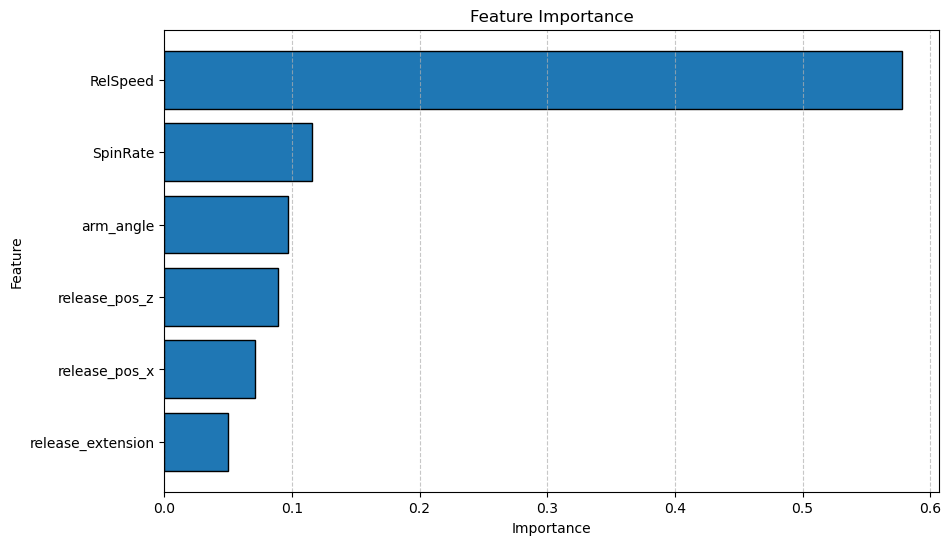

In [31]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Extract feature importances
feature_importances = ivb_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
importances_college_data = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_college_data['Feature'], importances_college_data['Importance'], edgecolor='black')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [32]:
with open('ivb_model.pkl', 'wb') as file:
    pickle.dump(ivb_model, file)

# Load the model
with open('ivb_model.pkl', 'rb') as file:
    ivb_model = pickle.load(file)

In [33]:
college_data['xiVB'] = ivb_model.predict(college_data[features])

college_data = college_data[~(college_data['InducedVertBreak'] >= 30)]
college_data['iVB_oe'] = college_data['InducedVertBreak'] - college_data['xiVB']

## Location Model

In [35]:
college_data.shape

(1098095, 179)

In [36]:
fastballs = ['Fastball', 'Sinker', 'Cutter']
college_fb = college_data[college_data['pitch_type'].isin(fastballs)]

most_common_fb = college_fb.groupby(['PitcherId', 'BatterSide'])['pitch_type'].agg(lambda x: x.mode().iloc[0]).reset_index()
most_common_fb = most_common_fb.rename(columns={'pitch_type': 'most_common_fb'})

college_fb = college_fb.merge(most_common_fb, on=['PitcherId', 'BatterSide'], how='left')

college_fb_filtered = college_fb[college_fb['pitch_type'] == college_fb['most_common_fb']]

average_metrics = college_fb_filtered.groupby(['PitcherId', 'BatterSide', 'most_common_fb']).agg({
    'RelSpeed': 'mean',
    'release_pos_x': 'mean',
    'release_pos_z': 'mean',
    'HorzBreak': 'mean',
    'InducedVertBreak': 'mean'
}).reset_index()

average_metrics = average_metrics.rename(columns={
    'RelSpeed': 'avg_RelSpeed',
    'release_pos_x': 'avg_release_pos_x',
    'release_pos_z': 'avg_release_pos_z',
    'HorzBreak': 'avg_HorzBreak',
    'InducedVertBreak': 'avg_InducedVertBreak'
})

college_data = college_data.merge(average_metrics, on=['PitcherId', 'BatterSide'], how='left')

In [37]:
conditions = [
    (college_data['BatterSide'] == 'Left') & (college_data['PitcherThrows'] == 1),
    (college_data['BatterSide'] == 'Left') & (college_data['PitcherThrows'] == 0),  
    (college_data['BatterSide'] == 'Right') & (college_data['PitcherThrows'] == 1),  
    (college_data['BatterSide'] == 'Right') & (college_data['PitcherThrows'] == 0) 
]

values = [0, 1, 2, 3]

college_data['platoon_state'] = np.select(conditions, values)

count_mapping = {
    (0, 0): 0,
    (0, 1): 1,
    (0, 2): 2,
    (1, 0): 3,
    (1, 1): 4,
    (1, 2): 5,
    (2, 0): 6,
    (2, 1): 7,
    (2, 2): 8,
    (3, 0): 9,
    (3, 1): 10,
    (3, 2): 11
}

college_data['count'] = college_data[['Balls', 'Strikes']].apply(tuple, axis=1).map(count_mapping)

In [ ]:
loc_features = ['RelSpeed', 'release_pos_x', 'release_pos_z', 'platoon_state', 
                'count', 'HorzBreak', 'InducedVertBreak', 'release_extension',
                'SpinRate', 'PlateLocHeight', 'PlateLocSide', 'SpinAxis', 
                'arm_angle', 'VertApprAngle', 'iVB_oe']

loc_target = 'delta_run_exp'

In [39]:
college_data = college_data[
    ~(
        ((college_data['pitch_type'] == 'Fastball') & (college_data['RelSpeed'] < 88)) |  # Fastball with RelSpeed < 88
        ((college_data['pitch_type'] == 'Sinker') & (college_data['RelSpeed'] < 85)) |    # Sinker with RelSpeed < 85
        (college_data['RelSpeed'] < 70)                                                   # Any pitch with RelSpeed < 70
    )
]

In [40]:
df = college_data.dropna(subset=loc_features + [loc_target])

X = df[loc_features]
y = df[loc_target]

best_rmse = float('inf')
best_catboost_model = None

def catboost_objective(trial):
    global best_rmse, best_catboost_model

    # Define hyperparameters for optimization
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1e-1, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=13)
    cv_scores = []

    for train_idx, val_idx in cv.split(X, y):
        cat_X_train, cat_X_val = X.iloc[train_idx], X.iloc[val_idx]
        cat_y_train, cat_y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the CatBoost model
        catboost_model = CatBoostRegressor(**params, random_seed=13, verbose=0)
        catboost_model.fit(cat_X_train, cat_y_train, eval_set=(cat_X_val, cat_y_val), early_stopping_rounds=50, verbose=0)

        cat_y_pred = catboost_model.predict(cat_X_val)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(cat_y_val, cat_y_pred))
        cv_scores.append(rmse)

    mean_rmse = np.mean(cv_scores)

    # Save the best model based on RMSE
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_catboost_model = catboost_model

    return mean_rmse

# Create and run Optuna study, optimizing to minimize RMSE
catboost_study = optuna.create_study(direction='minimize') 
catboost_study.optimize(catboost_objective, n_trials=50)

# Get the best hyperparameters from the Optuna study
best_catboost_params = catboost_study.best_params
print("Best CatBoost Params:", best_catboost_params)

[I 2025-08-21 18:47:38,261] A new study created in memory with name: no-name-e7b37169-d80e-47dd-8005-5f38cfa4a8c3
[I 2025-08-21 18:51:46,853] Trial 0 finished with value: 0.20971268061156004 and parameters: {'iterations': 1159, 'learning_rate': 0.001055576076793158, 'depth': 7, 'min_data_in_leaf': 19, 'l2_leaf_reg': 3.409323184367688, 'border_count': 137, 'bagging_temperature': 1.4177072118731981, 'random_strength': 0.07427369429518549}. Best is trial 0 with value: 0.20971268061156004.
[I 2025-08-21 18:53:16,523] Trial 1 finished with value: 0.2110302181652166 and parameters: {'iterations': 684, 'learning_rate': 0.0010536262501665615, 'depth': 4, 'min_data_in_leaf': 100, 'l2_leaf_reg': 0.0055783834698406, 'border_count': 103, 'bagging_temperature': 1.0988165272425572, 'random_strength': 0.004886753496910145}. Best is trial 0 with value: 0.20971268061156004.
[I 2025-08-21 18:55:25,051] Trial 2 finished with value: 0.20862001401041833 and parameters: {'iterations': 1291, 'learning_rate':

Best CatBoost Params: {'iterations': 1371, 'learning_rate': 0.02746150389789248, 'depth': 10, 'min_data_in_leaf': 21, 'l2_leaf_reg': 0.6033632384434426, 'border_count': 202, 'bagging_temperature': 9.965158539458555, 'random_strength': 0.029967286460853663}


In [41]:
with open('xrv_model.pkl', 'wb') as file:
    pickle.dump(best_catboost_model, file)

# Load the model
with open('xrv_model.pkl', 'rb') as file:
    xrv_model = pickle.load(file)

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importances = xrv_model.get_feature_importance()
feature_names = X.columns

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

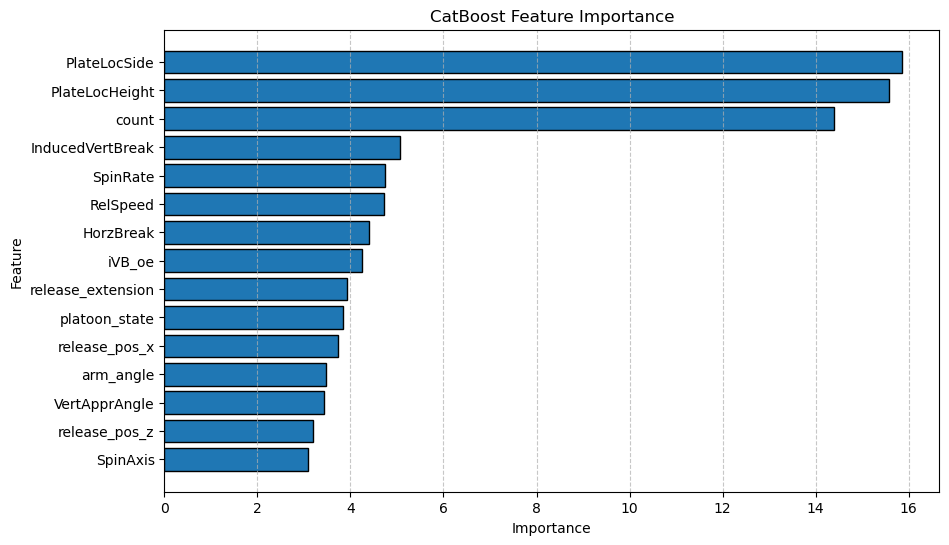

In [51]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], edgecolor='black')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()